# 循环神经网络的从零开始实现
:label:`sec_rnn_scratch`

在本节中，我们将根据 :numref:`sec_rnn` 中的描述，从头开始基于循环神经网络实现字符级语言模型。这样的模型将在 H. G. Wells 的时光机器数据集上训练。和前面 :numref:`sec_language_model` 中介绍过的一样，我们先读取数据集。


In [1]:
%matplotlib inline
import math
import numpy as np
import tensorflow as tf
from d2l import tensorflow as d2l


In [2]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [3]:
train_random_iter, vocab_random_iter = d2l.load_data_time_machine(
    batch_size, num_steps, use_random_iter=True)

## [**独热编码**]

回想一下，在 `train_iter` 中，每个词元都表示为一个数字索引。将这些索引直接输入神经网络可能会使学习变得困难。我们通常将每个词元表示为更具表现力的特征向量。最简单的表示称为*独热编码*（one-hot encoding），它在 :numref:`subsec_classification-problem` 中介绍过。

简言之，将每个索引映射为相互不同的单位向量：假设词汇表中不同词元的数目为$N$（即 `len(vocab)`），词元索引的范围为$0$到$N-1$。如果词元的索引是整数$i$，那么我们创建一个长度为$N$的全$0$向量，并将第$i$处的元素设置为$1$。此向量是原始词元的一个独热向量。索引为$0$和$2$的独热向量如下所示。


In [4]:
tf.one_hot(tf.constant([0, 2]), len(vocab))

<tf.Tensor: shape=(2, 28), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

我们每次采样的(**小批量数据形状是（批量大小, 时间步数）。**) `one_hot`函数将这样一个小批量数据转换成三维张量，张量的最后一个维度等于词汇表大小（`len(vocab)`）。我们经常转换输入的维度，以便获得形状为（时间步数, 批量大小, 词汇表大小）的输出。这将使我们能够更方便地通过最外层的维度，一步一步地更新小批量数据的隐藏状态。


In [5]:
X = tf.reshape(tf.range(10), (2, 5))
tf.one_hot(tf.transpose(X), 28).shape

TensorShape([5, 2, 28])

## 初始化模型参数

接下来，我们[**初始化循环神经网络模型的模型参数**]。隐藏单元数`num_hiddens`是一个可调的超参数。当训练语言模型时，输入和输出来自相同的词汇表。因此，它们具有相同的维度，即词汇表的大小。


In [6]:
def get_params(vocab_size, num_hiddens):
    num_inputs = num_outputs = vocab_size
    
    def normal(shape):
        return tf.random.normal(shape=shape,stddev=0.01,mean=0,dtype=tf.float32)

    # 隐藏层参数
    W_xh = tf.Variable(normal((num_inputs, num_hiddens)), dtype=tf.float32)
    W_hh = tf.Variable(normal((num_hiddens, num_hiddens)), dtype=tf.float32)
    b_h = tf.Variable(tf.zeros(num_hiddens), dtype=tf.float32)
    # 输出层参数
    W_hq = tf.Variable(normal((num_hiddens, num_outputs)), dtype=tf.float32)
    b_q = tf.Variable(tf.zeros(num_outputs), dtype=tf.float32)
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    return params

## 循环神经网络模型

为了定义循环神经网络模型，我们首先需要[**一个`init_rnn_state`函数在初始化时返回隐藏状态**]。函数的返回是一个张量，张量全用0填充，形状为（批量大小, 隐藏单元数）。在后面的章节中将会遇到隐藏状态包含多个变量的情况，而使用元组可以处理地更容易些。


In [7]:
def init_rnn_state(batch_size, num_hiddens):
    return (tf.zeros((batch_size, num_hiddens)), )

[**下面的`rnn`函数定义了如何在一个时间步内计算隐藏状态和输出。**]请注意，循环神经网络模型通过`inputs`最外层的维度实现循环，以便逐时间步更新小批量数据的隐藏状态`H`。此外，这里使用$\tanh$函数作为激活函数。如 :numref:`sec_mlp` 所述，当元素在实数上满足均匀分布时，$\tanh$函数的平均值为0。


In [8]:
def rnn(inputs, state, params):
    # `inputs`的形状：(`时间步数量`，`批量大小`，`词表大小`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # `X`的形状：(`批量大小`，`词表大小`)
    for X in inputs:
        X = tf.reshape(X,[-1,W_xh.shape[0]])
        H = tf.tanh(tf.matmul(X, W_xh) + tf.matmul(H, W_hh) + b_h)
        Y = tf.matmul(H, W_hq) + b_q
        outputs.append(Y)
    return tf.concat(outputs, axis=0), (H,)

定义了所有需要的函数之后，接下来我们[**创建一个类来包装这些函数**]，并存储从零开始实现的循环神经网络模型的参数。


In [9]:
class RNNModelScratch: #@save
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens,
                 init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state, params):
        X = tf.one_hot(tf.transpose(X), self.vocab_size)
        X = tf.cast(X, tf.float32)
        return self.forward_fn(X, state, params)

    def begin_state(self, batch_size):
        return self.init_state(batch_size, self.num_hiddens)

让我们[**检查输出是否具有正确的形状**]，例如，是否保证了隐藏状态的维数保持不变。


In [10]:
# 定义tensorflow训练策略
device_name = d2l.try_gpu()._device_name
strategy = tf.distribute.OneDeviceStrategy(device_name)

num_hiddens = 512
with strategy.scope():
    net = RNNModelScratch(len(vocab), num_hiddens, init_rnn_state, rnn)
state = net.begin_state(X.shape[0])
params = get_params(len(vocab), num_hiddens)
Y, new_state = net(X, state, params)
Y.shape, len(new_state), new_state[0].shape

(TensorShape([10, 28]), 1, TensorShape([2, 512]))

我们可以看到输出形状是（时间步数$\times$批量大小，词汇表大小），而隐藏状态形状保持不变，即（批量大小, 隐藏单元数）。

## 预测

让我们[**首先定义预测函数来生成`prefix`之后的新字符**]，其中的`prefix`是一个用户提供的包含多个字符的字符串。在循环遍历`prefix`中的开始字符时，我们不断地将隐藏状态传递到下一个时间步，但是不生成任何输出。这被称为“预热”（warm-up）期，因为在此期间模型会自我更新（例如，更新隐藏状态），但不会进行预测。预热期结束后，隐藏状态的值通常比刚开始的初始值更适合预测，从而预测字符并输出它们。


In [11]:
def predict_ch8(prefix, num_preds, net, vocab, params):  #@save
    """在`prefix`后面生成新字符。"""
    state = net.begin_state(batch_size=1)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: tf.reshape(tf.constant([outputs[-1]]), (1, 1)).numpy()
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state, params)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测`num_preds`步
        y, state = net(get_input(), state, params)
        outputs.append(int(y.numpy().argmax(axis=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

现在我们可以测试`predict_ch8`函数。我们将前缀指定为`time traveller ` ，并基于这个前缀生成10个后续字符。鉴于我们还没有训练网络，它会生成荒谬的预测结果。


In [12]:
predict_ch8('time traveller ', 10, net, vocab, params)

'time traveller jlkguqmmmm'

## [**梯度裁剪**]

对于长度为$T$的序列，我们在迭代中计算这$T$个时间步上的梯度，将会在反向传播过程中产生长度为$\mathcal{O}(T)$的矩阵乘法链。如 :numref:`sec_numerical_stability` 所述，当$T$较大时，它可能导致数值不稳定，例如可能导致梯度爆炸或梯度消失。因此，循环神经网络模型往往需要额外的支持来稳定训练。

一般来说，当解决优化问题时，我们对模型参数采用更新步骤，假定在向量形式的$\mathbf{x}$中，或者在小批量数据的负梯度$\mathbf{g}$方向上。例如，使用$\eta > 0$作为学习率时，在一次迭代中，我们将$\mathbf{x}$更新为$\mathbf{x} - \eta \mathbf{g}$。让我们进一步假设目标函数$f$表现良好，表示伴随常数 $L$ 的 *利普希茨连续*（Lipschitz continuous）。也就是说，对于任意$\mathbf{x}$和$\mathbf{y}$我们有：

$$|f(\mathbf{x}) - f(\mathbf{y})| \leq L \|\mathbf{x} - \mathbf{y}\|.$$

在这种情况下，我们可以安全地假设，如果我们通过$\eta \mathbf{g}$更新参数向量，那么：

$$|f(\mathbf{x}) - f(\mathbf{x} - \eta\mathbf{g})| \leq L \eta\|\mathbf{g}\|,$$

这意味着我们不会观察到超过$L \eta \|\mathbf{g}\|$的变化。这既是坏事也是好事。在坏的一面，它限制了取得进展的速度；而在好的一面，它限制了事情变糟的程度，当我们朝着错误的方向前进时。

有时梯度可能很大，从而优化算法可能无法收敛。我们可以通过降低$\eta$的学习率来解决这个问题。但是如果我们很少得到大的梯度呢？在这种情况下，这种做法似乎毫无道理。一个流行的替代方案是通过将梯度$\mathbf{g}$投影回给定半径（例如$\theta$）的球来裁剪梯度$\mathbf{g}$。如下式：

(**$$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}.$$**)

通过这样做，我们知道梯度范数永远不会超过$\theta$，并且更新后的梯度完全与$\mathbf{g}$的原始方向对齐。它还有一个值得拥有的副作用，即限制任何给定的小批量数据（以及其中任何给定的样本）对参数向量的影响，这赋予了模型一定程度的稳定性。梯度裁剪提供了一个快速修复梯度爆炸的方法。虽然它并不能完全解决问题，但它是众多有效的技术之一。

下面我们定义一个函数来裁剪模型的梯度，模型是从零开始实现的模型或由高级API构建的模型。另外请注意，我们计算了所有模型参数的梯度的范数。


In [13]:
def grad_clipping(grads, theta): #@save
    """裁剪梯度。"""
    theta = tf.constant(theta, dtype=tf.float32)
    norm = tf.math.sqrt(sum((tf.reduce_sum(grad ** 2)).numpy()
                        for grad in grads))
    norm = tf.cast(norm, tf.float32)
    new_grad = []
    if tf.greater(norm, theta):
        for grad in grads:
            new_grad.append(grad * theta / norm)
    else:
        for grad in grads:
            new_grad.append(grad)
    return new_grad

## 训练

在训练模型之前，让我们[**定义一个函数在一个迭代周期内训练模型**]。它与我们训练 :numref:`sec_softmax_scratch` 模型的方式有三个不同之处：

1. 序列数据的不同采样方法（随机采样和顺序分区）将导致隐藏状态初始化的差异。
1. 我们在更新模型参数之前裁剪梯度。这样的操作即使训练过程中某个点上发生了梯度爆炸，也能保证模型不会发散。
1. 我们用困惑度来评价模型。如 :numref:`subsec_perplexity` 所述，这样的度量确保了不同长度的序列具有可比性。

具体来说，当使用顺序分区时，我们只在每个迭代周期的开始位置初始化隐藏状态。由于下一个小批量数据中的第$i$个子序列样本与当前第$i$个子序列样本相邻，因此当前小批量数据最后一个样本的隐藏状态，将用于初始化下一个小批量数据第一个样本的隐藏状态。这样，存储在隐藏状态中的序列的历史信息可以在一个迭代周期内流经相邻的子序列。然而，在任何一点隐藏状态的计算，都依赖于同一迭代周期中前面所有的小批量数据，这使得梯度计算变得复杂。为了降低计算量，我们在处理任何一个小批量数据之前先分离梯度，使得隐藏状态的梯度计算总是限制在一个小批量数据的时间步内。

当使用随机抽样时，因为每个样本都是在一个随机位置抽样的，因此需要为每个迭代周期重新初始化隐藏状态。与 :numref:`sec_softmax_scratch` 中的 `train_epoch_ch3` 函数相同，`updater`是更新模型参数的常用函数。它既可以是从头开始实现的 `d2l.sgd` 函数，也可以是深度学习框架中内置的优化函数。


In [14]:
#@save
def train_epoch_ch8(net, train_iter, loss, updater, params, use_random_iter):
    """训练模型一个迭代周期（定义见第8章）。"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和, 词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化`state`
            state = net.begin_state(batch_size=X.shape[0])
        with tf.GradientTape(persistent=True) as g:
            g.watch(params)
            y_hat, state= net(X, state, params)
            y = tf.reshape(tf.transpose(Y), (-1))
            l = loss(y, y_hat)
        grads = g.gradient(l, params)
        grads = grad_clipping(grads, 1)
        updater.apply_gradients(zip(grads, params))
        
        # Keras默认返回一个批量中的平均损失
        # l_sum = l * float(d2l.size(y)) if isinstance(
        #     loss, tf.keras.losses.Loss) else tf.reduce_sum(l)
        metric.add(l * d2l.size(y), d2l.size(y))
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

[**循环神经网络模型的训练函数既支持从零开始实现，也可以使用高级API来实现。**]


In [15]:
#@save
def train_ch8(net, train_iter, vocab, num_hiddens, lr, num_epochs, strategy,
              use_random_iter=False):
    """训练模型（定义见第8章）。"""
    with strategy.scope():
        params = get_params(len(vocab), num_hiddens)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        updater = tf.keras.optimizers.SGD(lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, params)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
             net, train_iter, loss, updater, params, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    device = d2l.try_gpu()._device_name
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

[**现在，我们训练循环神经网络模型。**]因为我们在数据集中只使用10000个词元，所以模型需要更多的迭代周期来更好地收敛。


困惑度 1.0, 15892.6 词元/秒 /GPU:0


time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


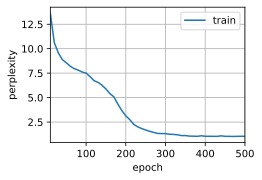

In [16]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, num_hiddens, lr, num_epochs, strategy)

[**最后，让我们检查一下使用随机抽样方法的结果。**]


In [17]:
params = get_params(len(vocab_random_iter), num_hiddens)
train_ch8(net, train_random_iter, vocab_random_iter, num_hiddens, lr,
          num_epochs, strategy, use_random_iter=True)

困惑度 1.5, 14404.6 词元/秒 /GPU:0


time traveller smiled are you sure we can move freely inspace ri
traveller smiled round at us then still smiling faintlyand 


从零开始实现上述循环神经网络模型，虽然有指导意义，但是并不方便。在下一节中，我们将学习如何改进循环神经网络模型，例如，如何使其实现地更容易，运行速度更快。

## 小结

* 我们可以训练一个基于循环神经网络的字符级语言模型，根据用户提供的文本的前缀生成后续文本。
* 一个简单的循环神经网络语言模型包括输入编码、循环神经网络模型和输出生成。
* 循环神经网络模型在训练以前需要初始化状态，不过随机抽样和顺序划分使用初始化方法不同。
* 当使用顺序划分时，我们需要分离梯度以减少计算量。
* 在进行任何预测之前，模型通过预热期进行自我更新（例如，获得比初始值更好的隐藏状态）。
* 梯度裁剪可以防止梯度爆炸，但不能应对梯度消失。

## 练习

1. 尝试说明独热编码等价于为每个对象选择不同的嵌入表示。
1. 通过调整超参数（如迭代周期数、隐藏单元数、小批量数据的时间步数、学习率等）来改善困惑度。
    * 你能降到多低？
    * 用可学习的嵌入表示替换独热编码，是否会带来更好的表现？
    * 它在 H. G. Wells 的其他书作为数据集时效果如何，例如[*星球大战*](http://www.gutenberg.org/ebooks/36)？
1. 修改预测函数，例如使用采样，而不是选择最有可能的下一个字符。
    * 会发生什么？
    * 调整模型使之偏向更可能的输出，例如，当$\alpha > 1$，从$q(x_t \mid x_{t-1}, \ldots, x_1) \propto P(x_t \mid x_{t-1}, \ldots, x_1)^\alpha$中采样。
1. 在不裁剪梯度的情况下运行本节中的代码会发生什么？
1. 更改顺序划分，使其不会从计算图中分离隐藏状态。运行时间会有变化吗？困惑度呢？
1. 用ReLU替换本节中使用的激活函数，并重复本节中的实验。我们还需要梯度裁剪吗？为什么？


[Discussions](https://discuss.d2l.ai/t/2104)
